In [32]:
from nilearn.datasets import fetch_haxby
haxby = fetch_haxby(n_subjects=2)

import numpy as np

%matplotlib inline

In [19]:
func_file = haxby.func[0]
target_file = haxby.session_target[0]

target = np.recfromcsv(target_file, delimiter=" ")  # check recfromtxt and pandas, make them find delimiter

In [21]:
labels = target['labels']
sessions = target['chunks']

In [26]:
face_place_mask = (labels == 'face') | (labels == 'house')

In [28]:
from sklearn.feature_selection import SelectKBest, f_classif

In [30]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_strategy='epi')
masker.fit(func)

NiftiMasker(detrend=False, high_pass=None, low_pass=None, mask_args=None,
      mask_img=None, mask_strategy='epi', memory=Memory(cachedir=None),
      memory_level=1, sample_mask=None, sessions=None, smoothing_fwhm=None,
      standardize=False, t_r=None, target_affine=None, target_shape=None,
      verbose=0)

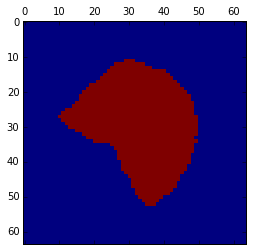

In [34]:
mask = masker.mask_img_.get_data()
import matplotlib.pyplot as plt
plt.matshow(mask[20])

In [35]:
X = masker.transform(func)

In [36]:
X.shape

(1452, 23707)

In [37]:
selector = SelectKBest(f_classif, 1)

In [38]:
x = selector.fit_transform(X[face_place_mask], labels[face_place_mask])

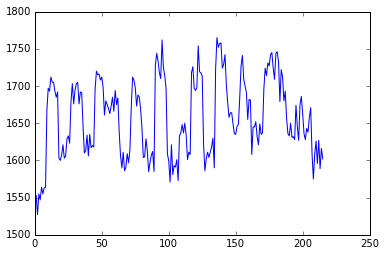

In [39]:
plt.plot(x)

[1500, 1800, -10, 10]

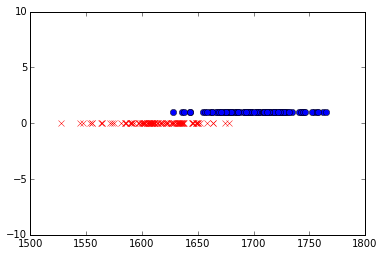

In [44]:
fp_labels = labels[face_place_mask]
plt.plot(x[fp_labels == 'face'], np.zeros_like(x[fp_labels=='face']), 'rx')
plt.plot(x[fp_labels == 'house'], np.ones_like(x[fp_labels=='house']), 'bo')
plt.axis([1500, 1800, -10, 10])

In [62]:
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(C=100000)

estimator.fit(x, fp_labels)

LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [63]:
sigmoid = 1. / (1 + np.exp(-(estimator.coef_[0] * x + estimator.intercept_[0]))).ravel()

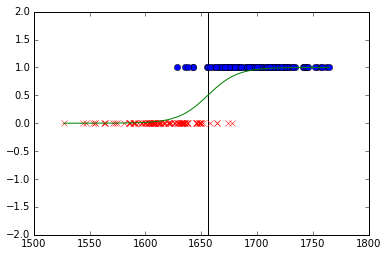

In [72]:
plt.plot(x[fp_labels == 'face'], np.zeros_like(x[fp_labels=='face']), 'rx')
plt.plot(x[fp_labels == 'house'], np.ones_like(x[fp_labels=='house']), 'bo')
plt.axis([1500, 1800, -2, 2])
order = x.ravel().argsort()
plt.plot(x.ravel()[order], sigmoid[order], 'g')
boundary = -estimator.intercept_[0] / estimator.coef_[0]
plt.vlines([boundary], -2, 2)

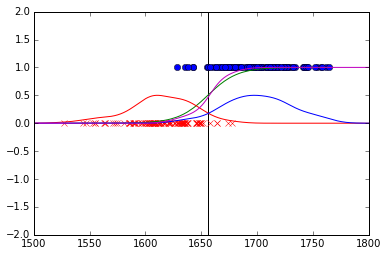

In [80]:
from scipy.stats import kde

d_face = kde.gaussian_kde(x[fp_labels == 'face'].ravel())
d_house = kde.gaussian_kde(x[fp_labels == 'house'].ravel())

p = np.linspace(1500, 1800, 1000)
p_face = d_face(p)
p_house = d_house(p)

decision = p_house / (p_face + p_house)

plt.plot(x[fp_labels == 'face'], np.zeros_like(x[fp_labels=='face']), 'rx')
plt.plot(x[fp_labels == 'house'], np.ones_like(x[fp_labels=='house']), 'bo')
plt.axis([1500, 1800, -2, 2])
order = x.ravel().argsort()
plt.plot(x.ravel()[order], sigmoid[order], 'g')
boundary = -estimator.intercept_[0] / estimator.coef_[0]
plt.vlines([boundary], -2, 2)

plt.plot(p, p_face / p_face.max() * .5, 'r')
plt.plot(p, p_house / p_house.max() * .5, 'b')
plt.plot(p, decision, 'm')

3.3297524877522573

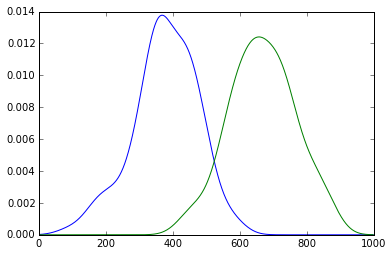

In [78]:
plt.plot(p_face)
plt.plot(p_house)

p_face.sum()

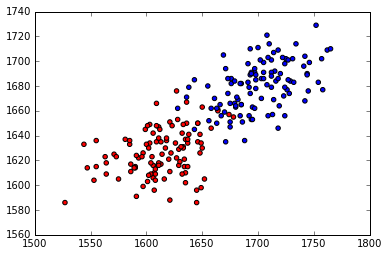

In [84]:
selector2 = SelectKBest(f_classif, 2)
x2 = selector2.fit_transform(X[face_place_mask], labels[face_place_mask])
colors = np.array(['r', 'b'])[(labels[face_place_mask] == 'house').astype('int')]
plt.scatter(x2.T[0], x2.T[1], c=colors)

In [82]:
plt.scatter?